In [74]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import KMeans
from scipy.special import boxcox1p
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import gc

from xgboost import plot_importance

In [75]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='Malgun Gothic',
              rc=custom_params)

In [76]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# train과 test데이터 차이 확인
print(f"train 칼럼 갯수 : {len(train.columns)}, test 칼럼 갯수 : {len(test.columns)}")
set1 = set(list(train.columns))
set2 = set(list(test.columns))
print(f"train칼럼에는 존재하지만 test칼럼에는 없는 칼럼 : {set1 - set2}")

train 칼럼 갯수 : 21, test 칼럼 갯수 : 20
train칼럼에는 존재하지만 test칼럼에는 없는 칼럼 : {'price'}


In [77]:
sub_id = test['id']
def data_sol(col):
    for i in col:
        i['date'] = i['date'].apply(lambda x: x[:6]).astype(int)

data_sol([train, test])

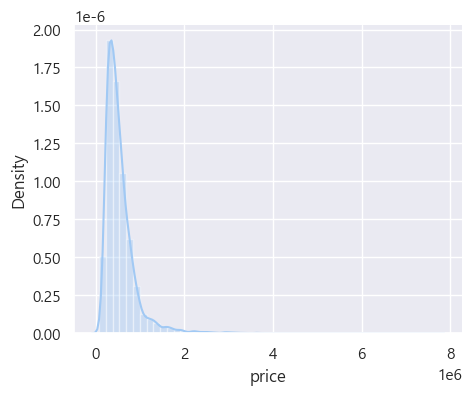

In [78]:
# price의 분포 확인
fig, ax = plt.subplots(figsize=(5, 4))
sns.distplot(train['price'])
plt.show()

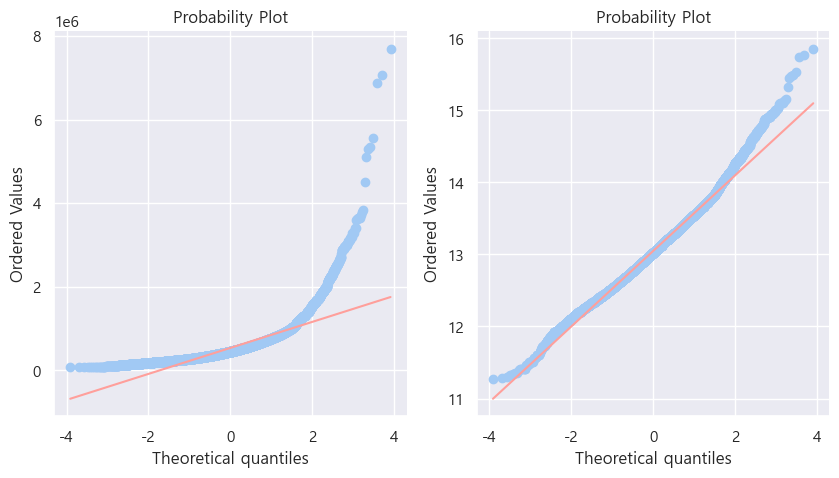

In [79]:
# price의 정규화시 데이터의 정규분포여부 확인
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
res = stats.probplot(train['price'], plot=plt)

fig.add_subplot(1, 2, 2)
res = stats.probplot(np.log1p(train['price']), plot=plt)

In [80]:
train['price'] = np.log1p(train['price'])

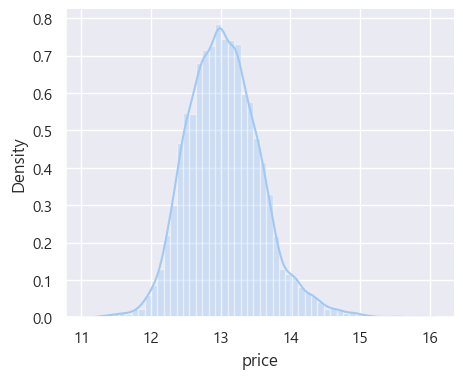

In [81]:
# 적용후 재 확인
fig, ax = plt.subplots(figsize=(5, 4))
sns.distplot(train['price'])
plt.show()

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


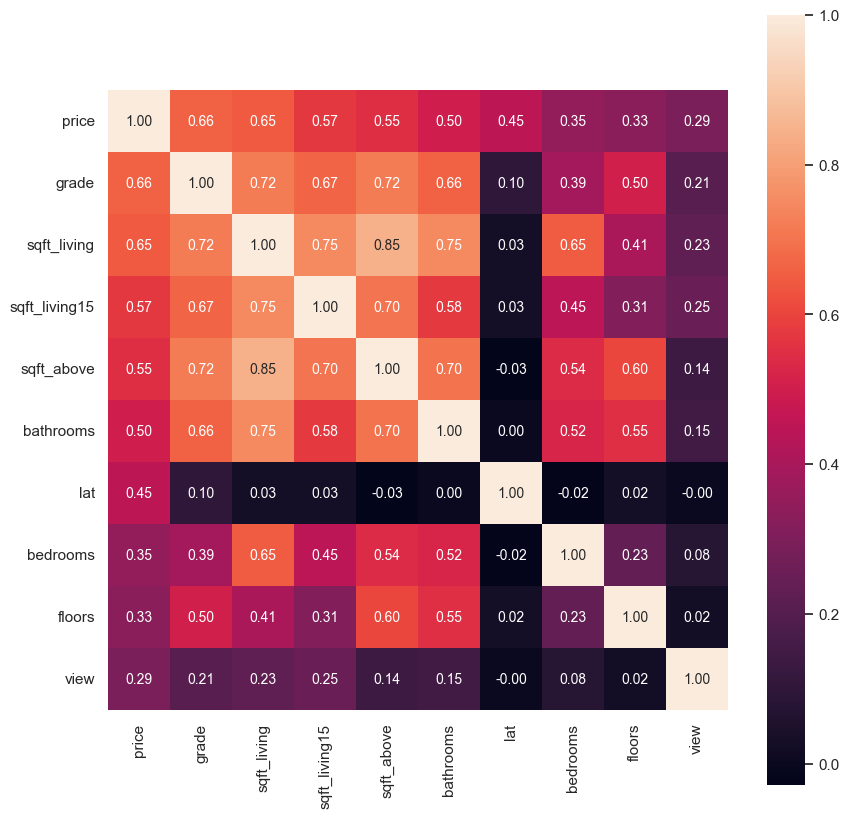

In [82]:
# correlation이 높은 상위 10개의 heatmap
# abs로 절대값으로 추출
import scipy as sp

cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 10} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)
plt.show()

In [83]:
# 상관계수가 가장 높은 grade의 종류 확인
train['grade'].nunique()

12

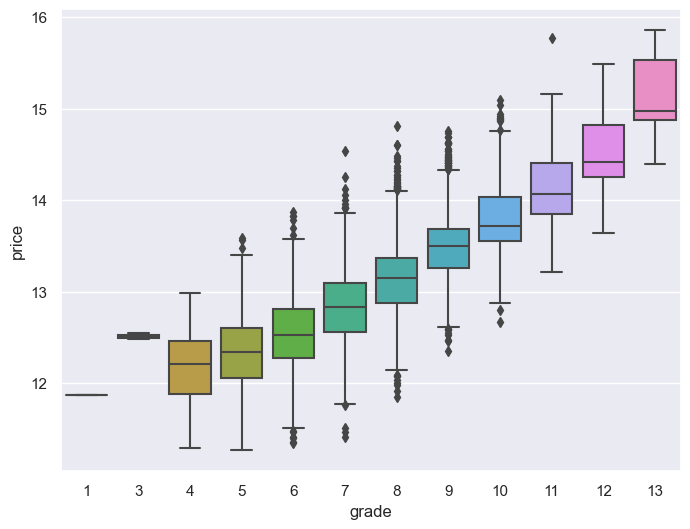

In [84]:
# grade를 기준으로 이상치 판단해보기 (boxplot사용)
data = pd.concat([train['price'], train['grade']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y='price', data=data)

* 1,3등급은 갯수가 적어보임
* 11등급에서 값이 이상한 이상치가 존재함

In [85]:
train.loc[(train['price'] > 15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [86]:
train.loc[train['grade'] == 3]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [87]:
train.loc[train['grade'] == 1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
13522,13522,201409,11.863589,0,0.0,290,20875,1.0,0,0,...,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850


In [88]:
# 이상치로 판단 후 제거
train = train.loc[train['id'] != 2302]
train = train.loc[train['id'] != 4123]
train = train.loc[train['id'] != 2775]
train = train.loc[train['id'] != 13522]

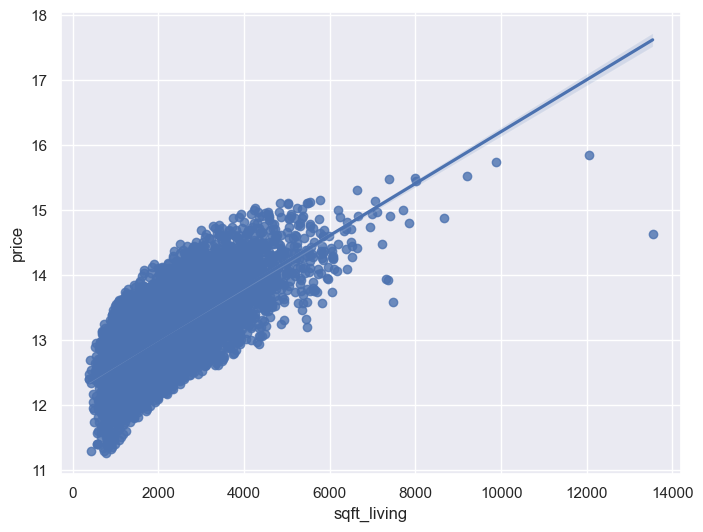

In [89]:
# 2번째로 상관계수가 높은 'sqft_living'을 기준으로 이상치 판단해보기 (regplot 사용)
data = pd.concat([train['price'], train['sqft_living']], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y='price', data=data)

In [90]:
# 13000이 넘어가는 한점을 이상치로 판단 후 제거
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [91]:
train = train.loc[train['id'] != 8912]

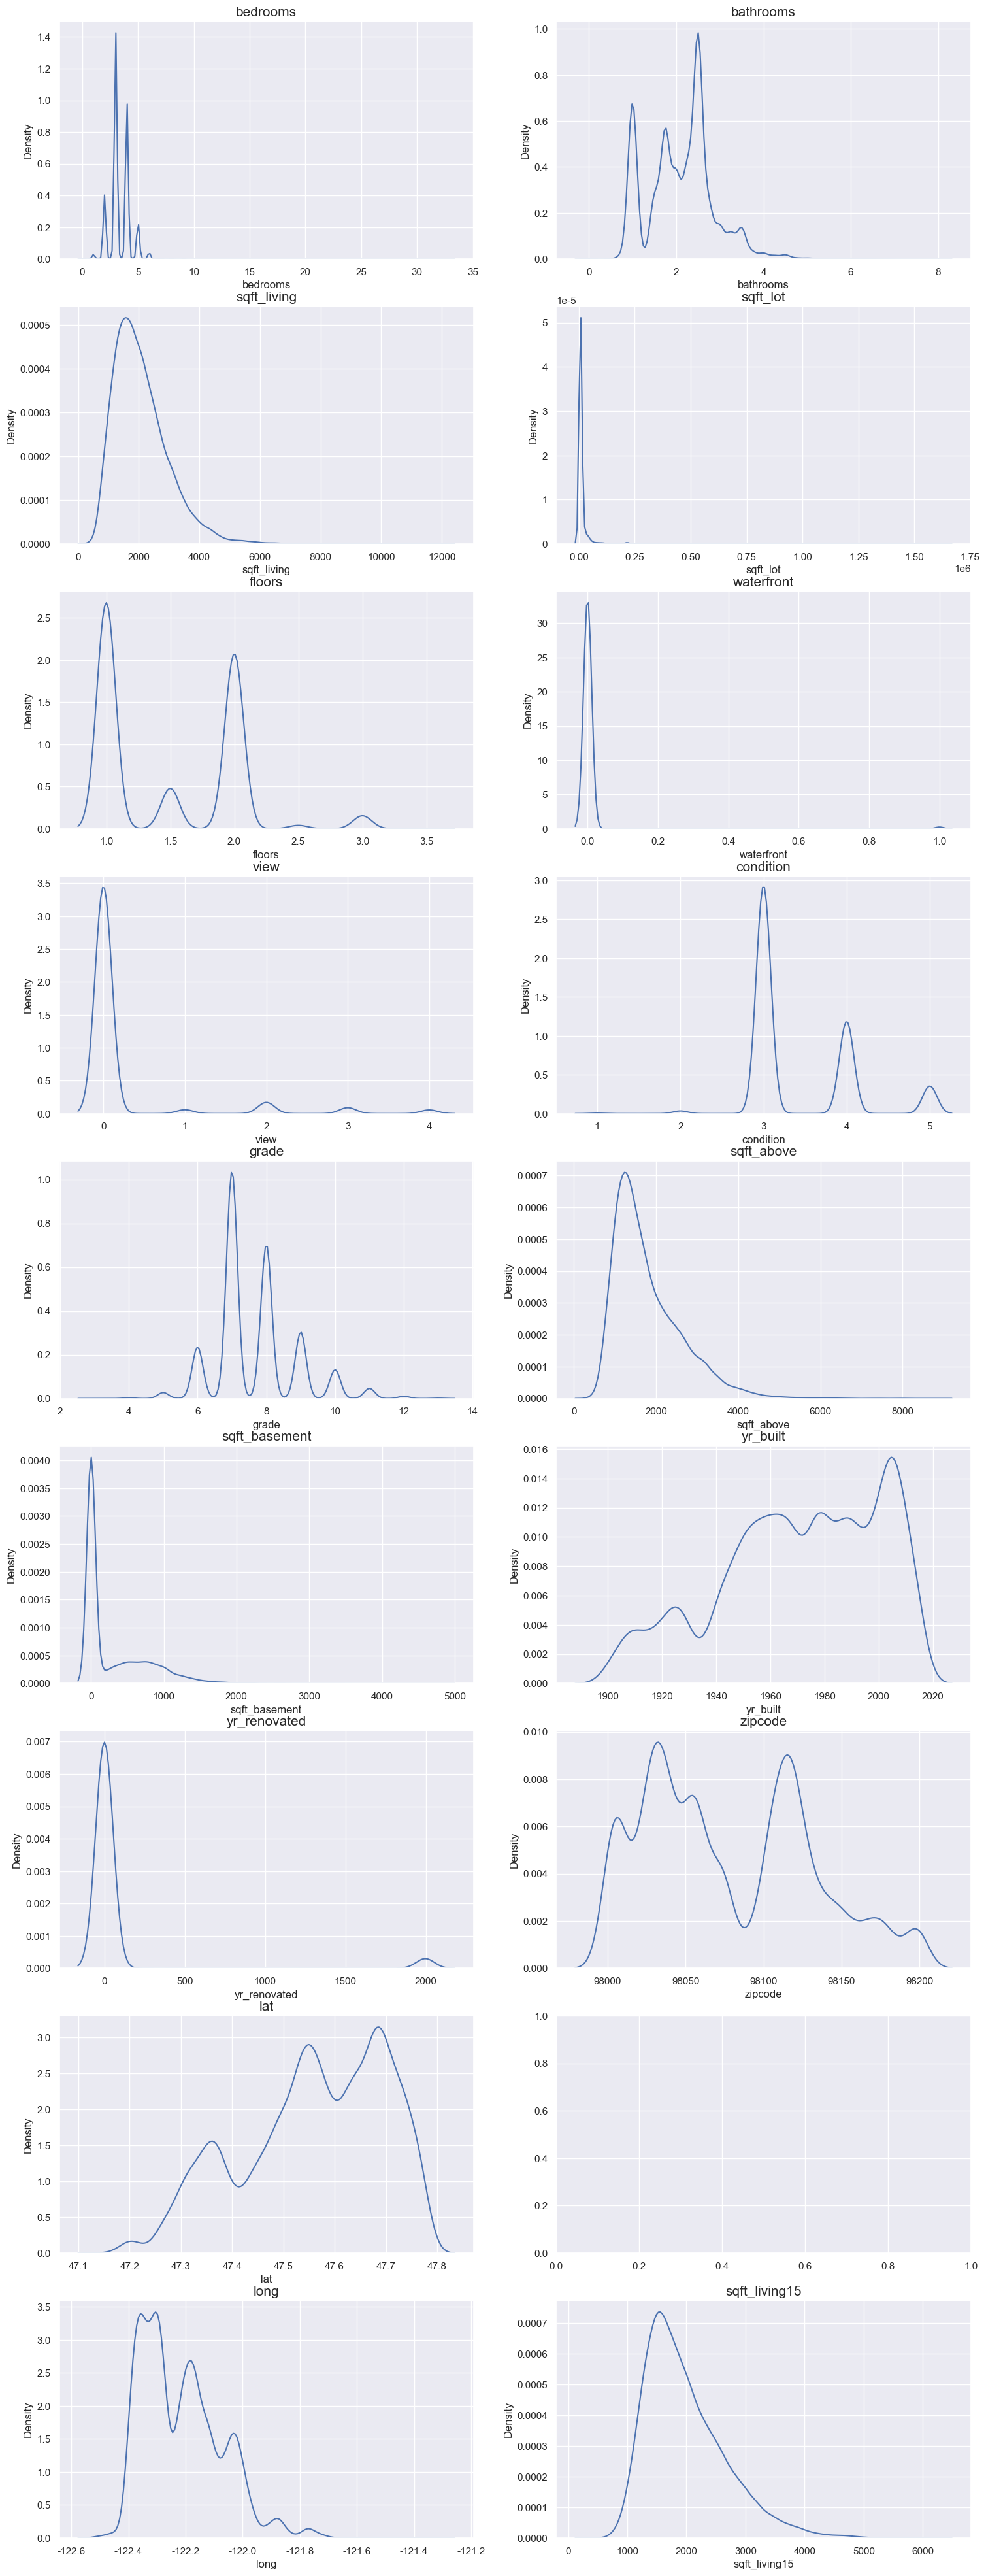

In [92]:
data = pd.concat((train, test), axis=0)

# 데이터의 분포 확인
fig, ax = plt.subplots(9, 2, figsize=(18, 50))

# id 변수는 제외하고 분포를 확인.
count = 3
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 18 :
            break

### 정규화 요소 선정 기준
* sqft가 붙은 요소들은 평방 피트를 의미함 = 해당 수치들은 정규화를 해주는게 유리
* 나머지 편향적인 분포를 보이는 요소들은 방의갯수, 집이 좋냐 안좋냐를 따지는 1,0 이기때문에 건들지 않기로함

In [93]:
# 정규화
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values) # 각 요소에 대해 자연로그 log(1 + x)를 반환
    test[c] = np.log1p(test[c].values)

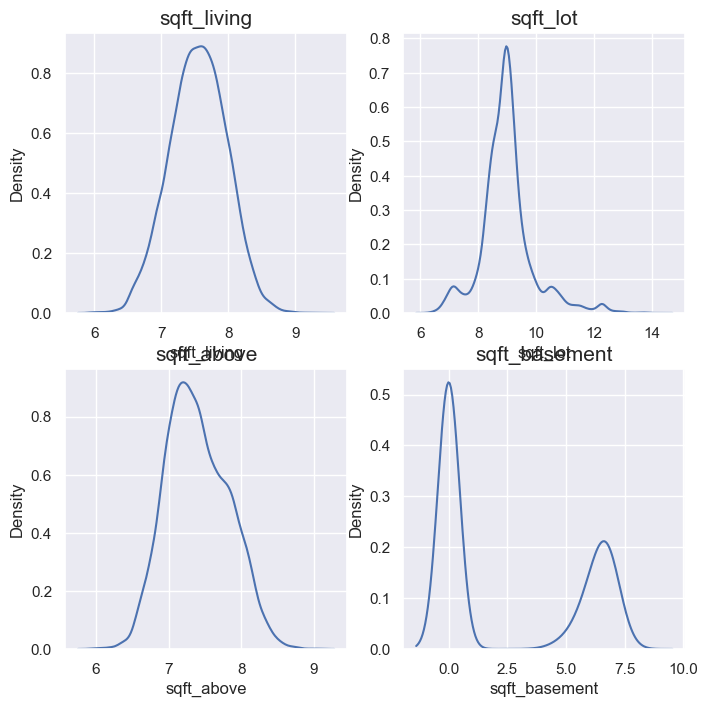

In [97]:
# 정규화 한 요소들 시각화로 확인
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

count = 0
for row in range(2):
    for col in range(2):
        if count == 4:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### train의 price를 이용해 test에 추가적인 요소 적용해보기

In [103]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


In [104]:
# 우편번호는 한 지역을 묶은거니 우편번호의 고유갯수 확인
train['zipcode'].nunique()

70

In [107]:
# 우편번호를 기준으로 가격 평균값 구하기
a = train[['zipcode', 'price']].groupby('zipcode').mean()
a

,price
zipcode,
98001,12.466371
98002,12.345955
98003,12.521928
98004,14.019739
98005,13.557592
...,...
98177,13.297695
98178,12.560076
98188,12.515986


In [108]:
# 평균값을 바로 넣으면 의미가 퇴색되기 때문에 cut을 이용하여 자체 등급 구분 하기
label = [j+1 for j in range(27)]
a['zip_level'] = pd.cut(a.price, bins=27, labels=label)
a = a.drop(['price'], axis=1)
a

,zip_level
zipcode,
98001,2
98002,1
98003,3
98004,21
98005,16
...,...
98177,12
98178,3
98188,3


In [109]:
# 해당 등급 train,test에 추가하기
train = train.merge(a, on='zipcode', how='left')
test = test.merge(a, on='zipcode', how='left')
train.zip_level = train.zip_level.astype(int)
test.zip_level = test.zip_level.astype(int)

In [111]:
# 새로 생성한 zip_level과 price의 상관관계 계산
print(train.price.corr(train.zip_level))

0.7271955478279714


In [114]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zip_level
0,15035,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,...,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,1690,7639,9
1,15036,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,...,6.957497,6.814543,1965,0,98136,47.5208,-122.393,1360,5000,11
2,15037,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,...,8.266421,7.333676,2001,0,98053,47.6561,-122.005,4760,101930,13
3,15038,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,...,6.957497,6.594413,1960,0,98146,47.5123,-122.337,1780,8113,5
4,15039,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,...,7.544861,0.000000,2003,0,98038,47.3684,-122.031,2390,7570,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,201406,3,1.75,7.313887,9.390075,1.0,0,0,3,...,7.313887,0.000000,2014,0,98010,47.3095,-122.002,1320,11303,7
6464,21499,201501,3,2.00,7.307202,7.027315,3.0,0,0,3,...,7.307202,0.000000,2014,0,98144,47.5699,-122.288,1400,1230,11
6465,21500,201502,3,2.50,7.178545,7.166266,2.0,0,0,3,...,7.074117,4.875197,2008,0,98116,47.5773,-122.409,1330,1265,12
6466,21501,201406,2,0.75,6.928538,7.208600,2.0,0,0,3,...,6.928538,0.000000,2009,0,98144,47.5944,-122.299,1020,2007,11


In [113]:
# target 분리
y = train['price']
del train['price']

In [115]:
sub_id = test['id']
del train['id']
del test['id']

In [116]:
# 모듈 import
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [117]:
# rmse 함수
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [118]:
# 모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

In [119]:
# 스코어 계산 함수
def get_scores(models, train, y):
        df = {}

        for model in models:
            model_name = model.__class__.__name__
            X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            if model_name in df:
                model_name = model_name + str(models.index(model))
            df[model_name] = rmse(y_test, y_pred)
            score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

        return (score_df)

In [120]:
from sklearn.model_selection import GridSearchCV

In [121]:
# GridSearch 함수 선언
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid,
                            scoring='neg_root_mean_squared_error',
                            cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    grid_model.cv_results_

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = -1 * results['score']
    results = results.sort_values(['RMSLE'])

    return results

In [122]:
random_state=2020

In [123]:
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [1400, 1600, 2000],
    'max_depth': [5, 7, 9, 11, 13],
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
    #'num_leaves' : [127, 255, 511]
}

In [124]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=-1)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [126]:
import sys
sys.setdefaultencoding('utf8')

AttributeError: module 'sys' has no attribute 'setdefaultencoding'

In [127]:
$ export PYTHONIOENCODING=utf-8

SyntaxError: invalid syntax (2484672751.py, line 1)